<a href="https://colab.research.google.com/github/DebjitHore/TensorflowDeveloperUdemy/blob/main/04_TransferLearningFeatureExtractionTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

In [ ]:
!nvidia-smi

Sat Jul 23 10:31:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-23 10:31:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   270MB/s    in 0.6s    

2022-07-23 10:31:46 (270 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zip_ref= zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

#Walk thorugh data directory

for dirpath, dirnames, filenames in os.walk("/content/10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.'")

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.'
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/hamburger'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.'
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.'
There are 0 directories and 75 images in '/content/10_food_classe

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
IMAGE_SHAPE= (224,224)
BATCH_SIZE=32

EPOCHS=10

train_dir= '/content/10_food_classes_10_percent/train'
test_dir= '/content/10_food_classes_10_percent/test'

train_datagen= ImageDataGenerator(rescale= 1/255.)
test_datagen= ImageDataGenerator(rescale= 1/255.)

print("Training Images")

train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                         target_size= IMAGE_SHAPE,
                                                         batch_size= BATCH_SIZE,
                                                         class_mode= "categorical")

test_data_10_percent= test_datagen.flow_from_directory(test_dir,
                                                         target_size= IMAGE_SHAPE,
                                                         batch_size= BATCH_SIZE,
                                                         class_mode= "categorical")

Training Images
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Introducing Callbacks (things to learn whilst our model trains)

* Callback is an extra functionality
* Tracking experiments with TensorBoard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training too long and overfitting through EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each experiment)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir= dir_name+"/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%")
  tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models with Tensorflow Hub

Access pretrained models at : https://www.tensorflow.org/hub OR tfhub.dev

* Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
!pip install --upgrade tensorflow_hub

import tensorflow_hub as hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# We are comparing following two models

resnet_url= "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url= "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  """
  Takes a tensorflow hub url and create a keras sequential model with it 

  Args:
   model_url(str): Tensorflow Hub feature extraction URL
   num_classes(int): Number of output neurons in the output layer, should be 
   equal to number of target classes, default 10

   Returns:
   An uncompiled Keras Sequential model with model_url as feature extractor layer 
   and Dense output layer with num_classes output neurons
  """
  #Download the pretrained model & save it

  feature_extractor_layer= hub.KerasLayer(model_url,
                                          trainable=False, #freeze the pretrained patters
                                          name= "feature_Extraction_Layer",
                                          input_shape= IMAGE_SHAPE+(3,))
  
  model= tf.keras.Sequential([
                              feature_extractor_layer,
                              layers.Dense(num_classes, activation='softmax', name= "output_layer")

  ])

  return model







## Creating and testing ResNet Tensorflow Hub Feature Extraction model


In [ ]:
resnet_model= create_model(resnet_url, 
                           num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_Extraction_Layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Compile our ResNet model

In [ ]:
resnet_model.compile(loss= tf.keras.losses.categorical_crossentropy,
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics= ['accuracy'])


In [ ]:
resnet_history= resnet_model.fit(train_data_10_percent, epochs= 5, steps_per_epoch=len(train_data_10_percent),
                 validation_data= test_data_10_percent, validation_steps= len(test_data_10_percent),
                 callbacks=[ create_tensorboard_callback(dir_name="tensorflow_hub",
                                                         experiment_name="resnet_50_V2")] )

Saving TensorBoard log files to: tensorflow_hub/resnet_50_V2/20220723-10%
Epoch 1/5
24/24 [==============================] - 32s 734ms/step - loss: 1.8785 - accuracy: 0.3880 - val_loss: 1.1293 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 15s 660ms/step - loss: 0.8811 - accuracy: 0.7333 - val_loss: 0.8176 - val_accuracy: 0.7444
Epoch 3/5
24/24 [==============================] - 16s 685ms/step - loss: 0.6176 - accuracy: 0.8227 - val_loss: 0.7272 - val_accuracy: 0.7736
Epoch 4/5
24/24 [==============================] - 15s 652ms/step - loss: 0.4678 - accuracy: 0.8800 - val_loss: 0.6854 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.3801 - accuracy: 0.9173 - val_loss: 0.6744 - val_accuracy: 0.7812


In [ ]:
# Plot loss curves

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
  model training history: Tensorflow history object

  Returns:
  Plots of training/validation loss and accuracy metrics

  """
  loss= history.history["loss"]
  val_loss= history.history["val_loss"]

  accuracy= history.history["accuracy"]
  val_accuracy= history.history["val_accuracy"]

  epochs= range(len(loss))

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")

  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

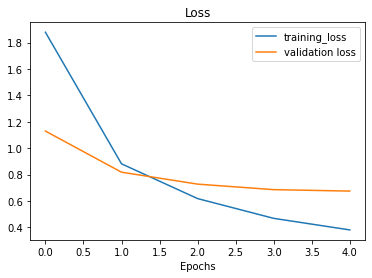

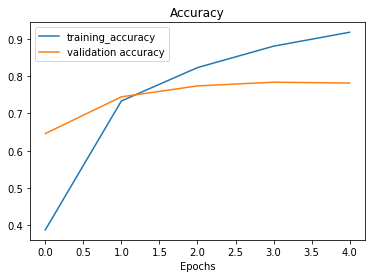

In [ ]:
plot_loss_curves(resnet_history)

## Creating and testing Efficient B0 Tensorflow Hub Feature Extraction model


In [ ]:
efficientnet_model= create_model(efficientnet_url, num_classes= train_data_10_percent.num_classes)

In [ ]:
efficientnet_model.compile(loss= tf.keras.losses.categorical_crossentropy,
                           optimizer= tf.keras.optimizers.Adam(),
                           metrics= ["accuracy"])

efficientnet_history= efficientnet_model.fit(train_data_10_percent, epochs=EPOCHS, steps_per_epoch=len(train_data_10_percent),
                       validation_data= test_data_10_percent, validation_steps=len(test_data_10_percent),
                      callbacks=[ create_tensorboard_callback(dir_name="tensorflow_hub",
                                                         experiment_name="resnet_50_V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet_50_V2/20220723-10%
Epoch 1/10
24/24 [==============================] - 25s 703ms/step - loss: 1.8301 - accuracy: 0.4107 - val_loss: 1.2888 - val_accuracy: 0.7356
Epoch 2/10
24/24 [==============================] - 16s 666ms/step - loss: 1.0579 - accuracy: 0.7613 - val_loss: 0.8648 - val_accuracy: 0.8132
Epoch 3/10
24/24 [==============================] - 15s 636ms/step - loss: 0.7550 - accuracy: 0.8440 - val_loss: 0.6932 - val_accuracy: 0.8420
Epoch 4/10
24/24 [==============================] - 15s 636ms/step - loss: 0.6052 - accuracy: 0.8733 - val_loss: 0.6094 - val_accuracy: 0.8516
Epoch 5/10
24/24 [==============================] - 15s 633ms/step - loss: 0.5109 - accuracy: 0.8960 - val_loss: 0.5528 - val_accuracy: 0.8632
Epoch 6/10
24/24 [==============================] - 15s 635ms/step - loss: 0.4429 - accuracy: 0.9133 - val_loss: 0.5195 - val_accuracy: 0.8656
Epoch 7/10
24/24 [==============================] - 15s 664ms/step -

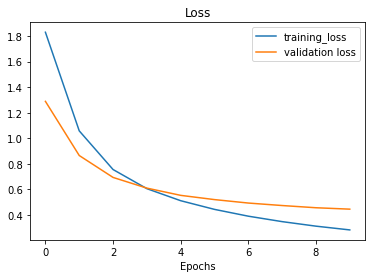

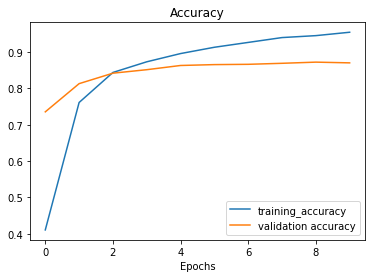

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning
* "As is" transfer learning- use existing model with no changes
* Feature extraction- prelearned patterns from an existing model
* Fine tuning transfer learning- use prelearned patterns of an existing models and fine tune many or all underlying layers




In [ ]:
len(efficientnet_model.layers[0].weights)

309

## Comparing our results with TensorBoard

In [ ]:
!pip install -U tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs ResNet50V2" \
--description "Comparing two different TF Hub feature extraction model architectures" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=9kcRvlckaJFhTmIlPdQ1fJyaHmjhls&prompt=consent&access_type=off

Tensorboard results uploaded at : https://tensorboard.dev/experiment/Nw6LRWa1QxmLC8S3Jz7RUQ/#scalars


In [ ]:
#List of experiments

!tensorboard dev list

https://tensorboard.dev/experiment/Nw6LRWa1QxmLC8S3Jz7RUQ/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   Nw6LRWa1QxmLC8S3Jz7RUQ
	Created              2022-07-23 10:49:51 (5 minutes ago)
	Updated              2022-07-23 10:49:55 (5 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  1843574
Total: 1 experiment(s)
